<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv04_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Fully-connected neural network in pytorch

In this notebook we will train a fully-connected neural network in pytorch. You can find its documentation here: https://pytorch.org/docs/stable/index.html

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt

We will work with a simple MNIST dataset that contains images of numbers that are filled into zip code boxes.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

x_np = np.asarray(mnist.data).astype('float32')/255
labels_np = np.asarray(mnist.target).astype('int64')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We can display the dataset.

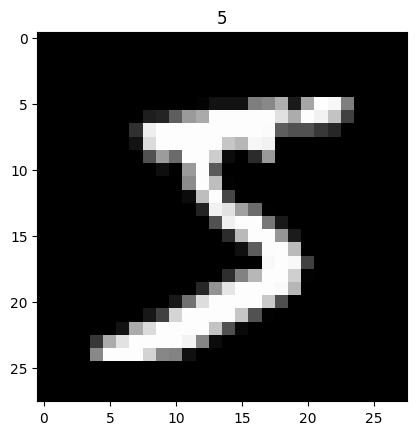

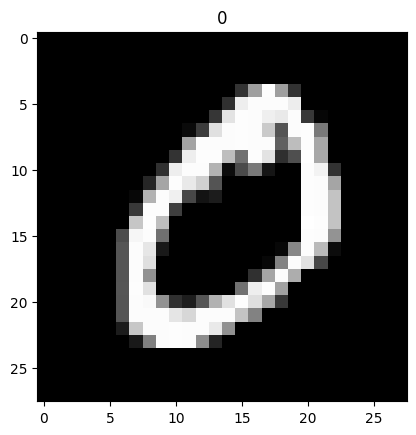

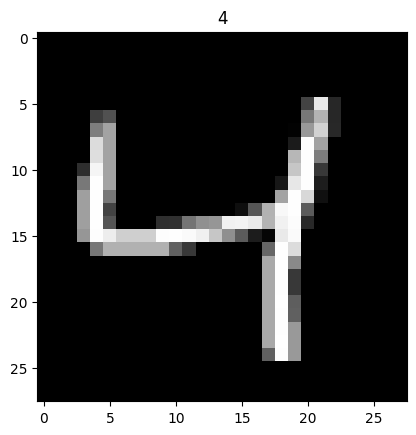

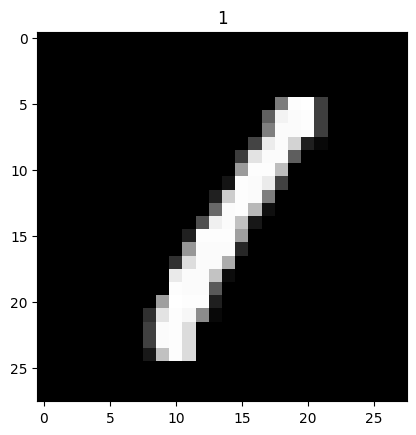

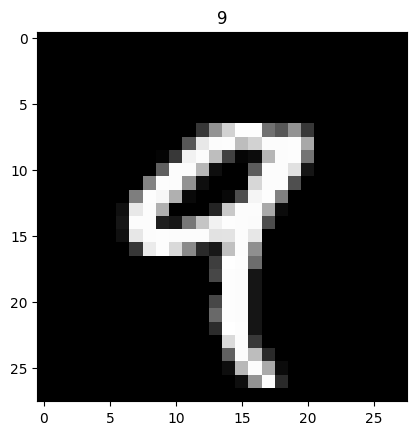

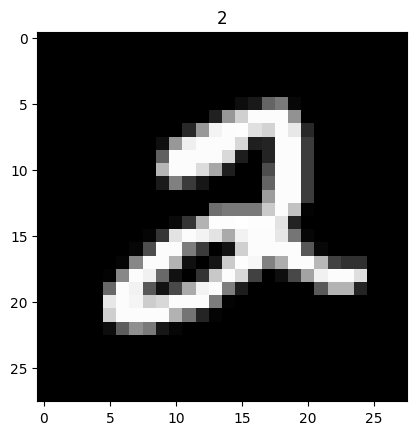

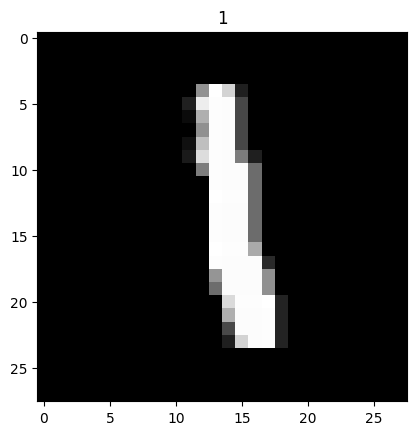

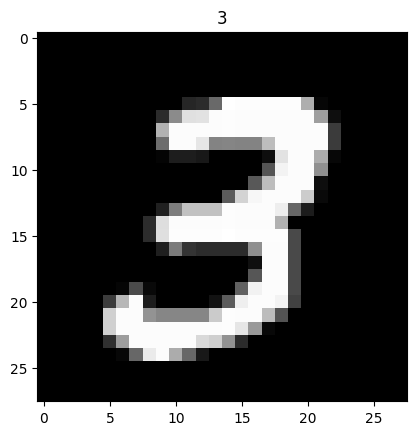

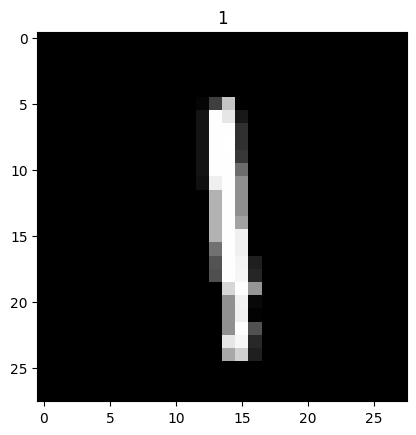

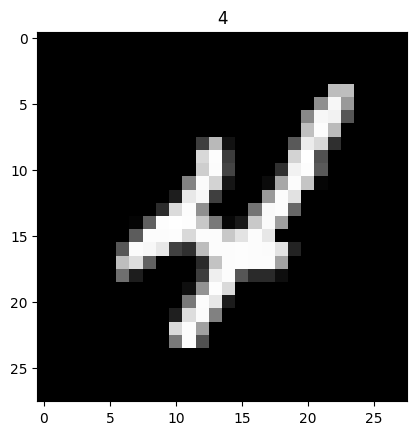

In [ ]:
for i in range(10):
  plt.imshow(np.reshape(x_np[i,],(28,28)), cmap='gray')
  plt.title(labels_np[i])
  plt.show()

## One-hot encoding

So far we have only worked with two classes. In that case, the representation was relatively simple. However, with more classes, it is necessary to choose a suitable way to represent these classes. It could be done e.g. one integer for each class and that should be output by the network. However, this is a problem, because e.g. if we have three categories: cat (0), dog (1), hamster (2), the network would essentially have to learn a representation in which the average of cat and hamster is dog, because (0 + 2) / 2 = 1. This doesn't make sense. Therefore, it will be better if the network has e.g. vector with the same length as the number of classes and each element will determine the probability of that class. With annotated data, we know exactly that only one category has a probability of one and the others zero, so it will look like this $(0, 0, 0, 1, 0, 0)$. Such a representation is called one-hot encoding. To convert labels, we can use Pytorch function `onehot`.

Since we will continue to work with tensors, we will also convert our input data to torch Tensory using `torch.from_numpy()`. The `one_hot` function will do the conversion automatically.

In [ ]:
from torch.nn.functional import one_hot

x = torch.from_numpy(x_np)

y = one_hot(torch.from_numpy(labels_np))

labels = torch.from_numpy(labels_np)

for i in range(10):
  print("labels: ", labels[i])
  print("one-hot: ", y[i])

labels:  tensor(5)
one-hot:  tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
labels:  tensor(0)
one-hot:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(9)
one-hot:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
labels:  tensor(2)
one-hot:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(3)
one-hot:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


### Loss function

As a loss function, we will use the so-called categorical crossentropy. It has the form

$$L(\vec{y}, \hat{\vec{y}}) = - \sum_{i=1}^n \hat{y}_i \text{log}(\vec{y}),$$

where $\vec{y}$ is the network output and $\hat{\vec{y}}$ are the one-hot encoded annotations. In order for it to work, we assume that the last layer is the softmax, which applies the function $\mathbb{R}^n \mapsto \mathbb{R}^n$ and for the input vector its $i$th component has the form:

$$\text{softmax}(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}.$$

This layer normalizes the outputs of the network so that we can interpret them as probabilities, since its outputs can be summed to 1. The problem is that this layer does the exp operation, but in the loss function we perform the logarithm. If we apply exp to some large number, we can get NaN and the subsequent logarithm will also be nan, even though it is true that:

$$ \text{log}(e^X) = X,$$

thus NaNs could be avoided using a clever implementation. That is why we will have two models, one for training and in which the loss from the inputs to the softmax will be calculated, and another for inference, where the softmax will be applied.

We can use `torch.nn.CrossEntropyLoss` as a loss.


### Optimization

In the past, we used optimization that we coded from scratch. However, Pytorch also offers this functionality directly implemented. Various optimization procedures are available in `torch.optim`

For now, we will use `torch.optim.SGD`. But this object also needs to be told what the parameters of the model are. We get them from the already constructed model.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1))

We can apply the model to the input data. However, the input is expected to usually be of size $n \times (28*28)$ even if $n = 1$. In this simple case, the network can also handle an input of size $28 * 28$, but you should keep this in mind when working with other netrworks.

In [ ]:
print(model_inference(x[:3]))
print(model_inference(x[0]))
print(model_inference(x[None, 0]))

print(model(x[:3]))
print(model(x[0]))
print(model(x[None, 0]))


tensor([[0.0961, 0.0940, 0.0948, 0.1004, 0.0902, 0.0952, 0.1107, 0.0967, 0.1082,
         0.1137],
        [0.0938, 0.0972, 0.0907, 0.1015, 0.0912, 0.0961, 0.1092, 0.0961, 0.1076,
         0.1165],
        [0.0930, 0.0967, 0.0910, 0.1007, 0.0907, 0.0965, 0.1087, 0.0977, 0.1091,
         0.1159]], grad_fn=<SoftmaxBackward0>)
tensor([0.0961, 0.0940, 0.0948, 0.1004, 0.0902, 0.0952, 0.1107, 0.0967, 0.1082,
        0.1137], grad_fn=<SoftmaxBackward0>)
tensor([[0.0961, 0.0940, 0.0948, 0.1004, 0.0902, 0.0952, 0.1107, 0.0967, 0.1082,
         0.1137]], grad_fn=<SoftmaxBackward0>)
tensor([[-0.0582, -0.0801, -0.0723, -0.0142, -0.1216, -0.0674,  0.0831, -0.0523,
          0.0603,  0.1100],
        [-0.0787, -0.0426, -0.1117,  0.0006, -0.1071, -0.0538,  0.0739, -0.0544,
          0.0585,  0.1386],
        [-0.0872, -0.0486, -0.1087, -0.0077, -0.1120, -0.0506,  0.0692, -0.0382,
          0.0722,  0.1329]], grad_fn=<AddmmBackward0>)
tensor([-0.0582, -0.0801, -0.0723, -0.0142, -0.1216, -0.0674,  0.08

## Preliminary testing of the model

When training the model, it is necessary to verify that it has sufficient capacity for the given problem. In this case, the capacity of the model is an expression of how large (or how complex) a set of functions can be modelled. If our model cannot even theoretically model the desired function (e.g. classifier), then it is not appropriate to use it. For example using a linear classifier on data that we know is linearly inseparable is an example of insufficient model capacity.

The easiest way to test this is to select a very small part (e.g. 1 minibatch) of data on which we want to train and check whether we can train the model 100 percent on such a small sample.

Through this testing, we will also verify that the training works and there is no problem with the data. This procedure is a suitable first step in network troubleshooting.

*Note:* In this type of testing, it is important not to have all examples from the same category, because in that case there is no need to think about the capacity of the model.

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for i in range(100):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)
  loss.backward()
  optimizer.step()

  print("Loss at step {}: {}".format(i, loss.item()))

  out = model(x_mini)
  out_classes = torch.argmax(out, dim=-1)
  acc = torch.sum(out_classes == labels_mini)/32
  print("Acc: ", acc.item())

Loss at step 0: 2.313600540161133
Acc:  0.09375
Loss at step 1: 2.3035836219787598
Acc:  0.09375
Loss at step 2: 2.2944579124450684
Acc:  0.09375
Loss at step 3: 2.285984992980957
Acc:  0.125
Loss at step 4: 2.2781386375427246
Acc:  0.15625
Loss at step 5: 2.2703664302825928
Acc:  0.15625
Loss at step 6: 2.2620790004730225
Acc:  0.1875
Loss at step 7: 2.253408193588257
Acc:  0.25
Loss at step 8: 2.2445425987243652
Acc:  0.3125
Loss at step 9: 2.234890937805176
Acc:  0.4375
Loss at step 10: 2.224762201309204
Acc:  0.46875
Loss at step 11: 2.2141916751861572
Acc:  0.46875
Loss at step 12: 2.2031567096710205
Acc:  0.5
Loss at step 13: 2.1913883686065674
Acc:  0.46875
Loss at step 14: 2.1791412830352783
Acc:  0.46875
Loss at step 15: 2.1662166118621826
Acc:  0.46875
Loss at step 16: 2.1522603034973145
Acc:  0.46875
Loss at step 17: 2.137108564376831
Acc:  0.46875
Loss at step 18: 2.120929479598999
Acc:  0.53125
Loss at step 19: 2.1030874252319336
Acc:  0.5625
Loss at step 20: 2.08407306671

If we create a model that does not have enough capacity the network will fail. If we create a network with one hidden layer with just one neuron it won't be able to represent the classes.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 1), ReLU(), Linear(1, 10))
model_inference = Sequential(model, Softmax(dim=-1))

ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for i in range(10000):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)
  loss.backward()
  optimizer.step()

  if i % 1000 == 999:
    print("Loss at step {}: {}".format(i, loss.item()))
    out = model_inference(x_mini)
    out_classes = torch.argmax(out, dim=-1)
    acc = torch.sum(out_classes == labels_mini)/32
    print("Acc: ", acc.item())

Loss at step 999: 1.7732352018356323
Acc:  0.34375
Loss at step 1999: 1.5861635208129883
Acc:  0.34375
Loss at step 2999: 1.4845088720321655
Acc:  0.46875
Loss at step 3999: 1.4174015522003174
Acc:  0.46875
Loss at step 4999: 1.3673789501190186
Acc:  0.46875
Loss at step 5999: 1.3304738998413086
Acc:  0.46875
Loss at step 6999: 1.302799105644226
Acc:  0.46875
Loss at step 7999: 1.2803232669830322
Acc:  0.46875
Loss at step 8999: 1.2596745491027832
Acc:  0.46875
Loss at step 9999: 1.2382862567901611
Acc:  0.46875


## train/val/test

During further work with the capacity of the model, we will need to define the so-called split our data. We do this split so that we can verify whether our model can really achieve good results on data that was not used for training.

Data that the model has not seen will be referred to as test data. We only use this data to verify the results.

So we have data left for training. But the problem is that we have two types of optimization. By one optimization (eg SGD) we select the model parameters themselves. We do the second optimization as users by choosing the optimization algorithm for the first type of optimization. We also select the parameters of this optimization and other things such as the choice of model architecture itself, initialization algorithm, minibatch size, training length, etc. We often refer to these things as so-called hyperparameters.

In order to be able to choose in this way, we always first train (the first type of optimization) on the training set and we then verify the parameters trained in this way on the validation set. These results will then allow us to implement the second type of optimization and thus compare the results for different types of optimization.

The reason why we do not do this on the test set is that it may happen that the choice of hyperparameters is also such that we have chosen them in such a way that they fit exactly on the validation set.

We typically divide the data in the ratio 80/10/10, or 60/20/20, etc., but it depends on the given task and the amount of data. Similarly, we will divide the MNIST dataset.

In [ ]:
x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

We will use PyTorch utils for iterating over the data. We first create a `Dataset` object and then a `DataLoader` object, which will provide us with an iterator, through which we will iterate the data after the batches or minibatches.

The principle of the SGD (stochastic gradient descent) method also lies in minibatches. In it, we do not optimize over the entire training set, but over a randomly selected smaller number of samples. This has the advantage that the whole process has smaller memory requirements and at the same time it introduces an element of randomness into the optimization, which makes it possible to get out of inappropriate regions of the parameter space such as local minima.

Thus, during training, we will iterate through randomly selected examples from the training set until we use all of them. This is called one epoch of training. Then we have the accuracy and loss printed on the validation set to verify that the network is really learning. In doing so, we use `torch.no_grad()` so that PyTorch knows that gradients do not need to be calculated and thus does not waste memory and time on intermediate calculations.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax

from torch.utils.data import TensorDataset, DataLoader

data_train = TensorDataset(x_train, labels_train)
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)

data_val = TensorDataset(x_val, labels_val)
dataloader_val = DataLoader(data_val, batch_size=32)

data_test = TensorDataset(x_test, labels_test)
dataloader_test = DataLoader(data_test, batch_size=32)

model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for e in range(10):
  model.train()
  for i, batch in enumerate(dataloader_train):
    x, y = batch
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    for i, batch in enumerate(dataloader_val):
      x, y = batch

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / 10000))

Loss at epoch: 0 step 0: 2.295038938522339
Loss at epoch: 0 step 100: 2.260009288787842
Loss at epoch: 0 step 200: 2.2383604049682617
Loss at epoch: 0 step 300: 2.209061861038208
Loss at epoch: 0 step 400: 2.036203384399414
Loss at epoch: 0 step 500: 1.7772984504699707
Loss at epoch: 0 step 600: 1.5849308967590332
Loss at epoch: 0 step 700: 1.3792327642440796
Loss at epoch: 0 step 800: 1.1129281520843506
Loss at epoch: 0 step 900: 0.8716685175895691
Loss at epoch: 0 step 1000: 0.9729028940200806
Loss at epoch: 0 step 1100: 0.8459725975990295
Loss at epoch: 0 step 1200: 0.7961578965187073
Loss at epoch: 0 step 1300: 0.6821461915969849
Loss at epoch: 0 step 1400: 0.4202955961227417
Loss at epoch: 0 step 1500: 0.7264595627784729
Val loss at epoch 0: 0.5401731412441205
Val acc at epoch 0: 0.8566
Loss at epoch: 1 step 0: 0.3854365646839142
Loss at epoch: 1 step 100: 0.2770329415798187
Loss at epoch: 1 step 200: 0.53268963098526
Loss at epoch: 1 step 300: 0.829586923122406
Loss at epoch: 1 s

## Saving the model

Of course, we would ideally like to save the model. This can be achieved by extracting the model parameters and saving them. However, the model does not remember the structure, so it is suitable e.g. in the code create a class to create the model. But we will do that later.

In [ ]:
torch.save(model.state_dict(), 'saved_model.pth')

softmax = Softmax(dim=-1)

new_model = Sequential(Linear(28 * 28, 30),
                       ReLU(),
                       Linear(30, 20),
                       ReLU(),
                       Linear(20, 10))

print(softmax(new_model(x[0])))

new_model.load_state_dict(torch.load('saved_model.pth'))

print(softmax(new_model(x[0])))

newer_model = Sequential(Linear(28 * 28, 60),
                       ReLU(),
                       Linear(60, 20),
                       ReLU(),
                       Linear(20, 10))

# this should throw an error
newer_model.load_state_dict(torch.load('saved_model.pth'))


tensor([0.0888, 0.1160, 0.0995, 0.1040, 0.0886, 0.1188, 0.0923, 0.0746, 0.0915,
        0.1258], grad_fn=<SoftmaxBackward0>)
tensor([8.9899e-07, 9.8671e-01, 1.3384e-03, 3.0065e-03, 3.2417e-04, 5.3086e-04,
        3.0447e-04, 4.0205e-04, 7.2266e-03, 1.5119e-04],
       grad_fn=<SoftmaxBackward0>)


RuntimeError: ignored

## Exercise 1 - hyperparameter optimization and testing

Modify the code above and try to find the optimal training hyperparameters. So, in this case, try to change the learning rate in the optimizer constructor, so that you achieve the best accuracy on the validation data. Different learning rates have need different amount of training steps so the amount of training epochs should be such that you stop seeing any new improvements on the validation data, but to keep the runtime low you can simply stop at 10 epochs.

Also write the code that tests the output model on the test data.


In [ ]:
...

Val acc after 1 epochs for lr 0.001: 0.1415
Val acc after 2 epochs for lr 0.001: 0.3541
Val acc after 3 epochs for lr 0.001: 0.4487
Val acc after 4 epochs for lr 0.001: 0.5834
Val acc after 5 epochs for lr 0.001: 0.6724
Val acc after 6 epochs for lr 0.001: 0.7543
Val acc after 7 epochs for lr 0.001: 0.8
Val acc after 8 epochs for lr 0.001: 0.8249
Val acc after 9 epochs for lr 0.001: 0.8439
Val acc after 10 epochs for lr 0.001: 0.8555
Val acc after 1 epochs for lr 0.01: 0.8591
Val acc after 2 epochs for lr 0.01: 0.9029
Val acc after 3 epochs for lr 0.01: 0.9133
Val acc after 4 epochs for lr 0.01: 0.9232
Val acc after 5 epochs for lr 0.01: 0.9251
Val acc after 6 epochs for lr 0.01: 0.9356
Val acc after 7 epochs for lr 0.01: 0.9402
Val acc after 8 epochs for lr 0.01: 0.9453
Val acc after 9 epochs for lr 0.01: 0.9468
Val acc after 10 epochs for lr 0.01: 0.9508
Val acc after 1 epochs for lr 0.03: 0.8979
Val acc after 2 epochs for lr 0.03: 0.9136
Val acc after 3 epochs for lr 0.03: 0.9267
Va

## Exercise 2 - learning rate scheduler

When training, it is sometimes appropriate to start with a larger training step and later switch to a smaller one. For this purpose, it is advisable to use the variable setting of the learning step. Try to implement it according to the documentation, e.g. [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) you can also choose another type of scheduler.

In [ ]:
...

Val acc after 1 epochs: 0.9322
Val acc after 2 epochs: 0.9469
Val acc after 3 epochs: 0.9557
Val acc after 4 epochs: 0.9644
Val acc after 5 epochs: 0.9649
Val acc after 6 epochs: 0.967
Val acc after 7 epochs: 0.9666
Val acc after 8 epochs: 0.9666
Val acc after 9 epochs: 0.9669
Val acc after 10 epochs: 0.9669


## Keras

Finally, these blocks show hot to create a fully connected network in keras. Keras is an API for tensorflow, which is more pleasant to use than direct tensorflow. Its use is similar to PyTorch, but you don't need to write your own training cycle.

In [ ]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(30, activation='sigmoid'))
model.add(keras.layers.Dense(20, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))

loss = keras.losses.categorical_crossentropy
model.compile(loss=loss,
              optimizer='sgd',
              metrics=['accuracy'])


y_keras = keras.utils.to_categorical(labels_np)

history = model.fit(x_np[:50000], y_keras[:50000], validation_data = (x_np[50000:60000], y_keras[50000:60000]), batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.2578 - accuracy: 0.2321 - val_loss: 2.1775 - val_accuracy: 0.3643
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.0526 - accuracy: 0.5157 - val_loss: 1.8758 - val_accuracy: 0.6068
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6744 - accuracy: 0.6111 - val_loss: 1.4531 - val_accuracy: 0.6977
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.3165 - accuracy: 0.6944 - val_loss: 1.1635 - val_accuracy: 0.7426
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.0911 - accuracy: 0.7386 - val_loss: 0.9775 - val_accuracy: 0.7800
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9361 - accuracy: 0.7691 - val_loss: 0.8394 - val_accuracy: 0.8033
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8158 - accuracy: 0.7941 - val_loss: 0.7310 - val_accuracy:

We can also plot the losses and accuracies as they evolved during training.

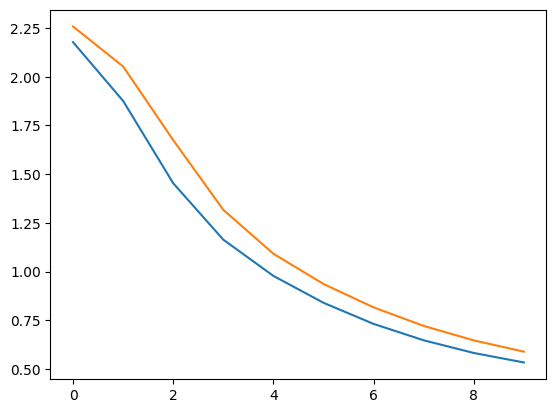

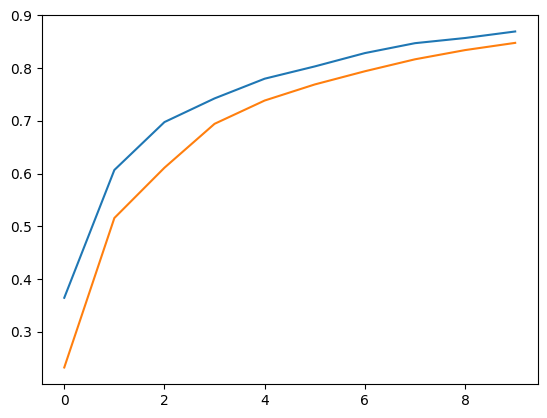

In [ ]:
from matplotlib import pyplot as plt

plt.plot(np.arange(10), history.history['val_loss'])
plt.plot(np.arange(10), history.history['loss'])
plt.show()
plt.plot(np.arange(10), history.history['val_accuracy'])
plt.plot(np.arange(10), history.history['accuracy'])
plt.show()